In [1]:
import matplotlib.pyplot as plt
import numpy as np
import num_methods


In [2]:
#x : phi1 phi2 pho y11 y21 y12 y22
agentsNum = 2
g_constants = {'rhoMax': 1.0, 'nu': np.array([0.75, 0.75]), 'alpha': np.array([0.03, 0.03]), 'beta': np.array([0.1, 0.1]), 'z': np.array([1.75, 1.75]), 'k': 0.25, 'ics': np.array([1.0, 1.0, 0.0]), 'uMin': 0.0, 'uMax': 0.9, 'T': 1.0}
g_stepSize = 0.01
g_coefs = np.ones(4)

def g_W(phi):
    #phi: phi1 phi2
    return phi

def g_dW(phi):
    return np.ones(phi.shape)
    
def g_R(phi):
    return phi

def g_dR(phi):
    return np.ones(phi.shape)

def g_C0(rho):
    return rho

def g_C(u):
    return u*u*g_constants['alpha']

def g_V(t):
    res = np.zeros(agentsNum)
    time = t / g_constants['T']
    res[0] = max(g_coefs[0]*time + g_coefs[2], 0.0)
    res[1] = max(g_coefs[1]*time + g_coefs[3], 0.0)
    return res

def parseX(x, agNum):
    phi = x[:agNum]
    rho = x[agNum]
    y1 = x[agNum+1:2*agNum +1]
    y2 = x[2*agNum +1: 3*agNum +1]
    return phi,rho,y1,y2

In [3]:
def agentResponse():
    solver = num_methods.equations.EqSolver( shootingFunc, 2*agentsNum, constArgs=(g_constants['ics'], g_V), eps = g_stepSize )
    y = solver.solve('Newton')
    solver = num_methods.ode.ODESolver(ode, np.append(g_constants['ics'], y), [0.0, g_constants['T']], ufunc = ufunc, usize = agentsNum, constArgs=(g_constants['ics'], g_V), h=g_stepSize)
    t, res, u = solver.solve('FinitDiff')
    return t, res, u

In [4]:
#constArgs - (ics, V(t))
#ics : [phi10, phi20, rho0]
def shootingFunc(y0, constArgs):
    ics, V = constArgs
    ics = np.append(ics, y0)#[phi10, phi20, rho0, y011, y021, y012, y022]
    solver = num_methods.ode.ODESolver(ode, ics, [0.0, g_constants['T']], ufunc = ufunc, usize = agentsNum, constArgs = constArgs, h=g_stepSize)
    _, res, _ = solver.solve('FinitDiff')
    return res[agentsNum+1:3*agentsNum +1, -1]#agentsNum+1:3*agentsNum +1

In [5]:
def ode(t, x, u, constArgs):
    phi, rho, y1, y2 = parseX(x, agentsNum)
    ics, V = constArgs
    v = V(t)
    #rho = np.full(agentsNum, rho)
    W = g_W(phi)
    dW = g_dW(phi)
    res = np.zeros(x.shape)
    res[:agentsNum] = -g_constants['beta']*phi + g_constants['nu'] * (g_constants['z']*g_R(phi) - W*g_C(u) - rho*v*W*(1.0-u)/g_constants['rhoMax'])
    res[agentsNum] = -g_constants['k']*rho + W[0]*(1.0-u[0]) + W[1]*(1.0-u[1])
    res[agentsNum+1:2*agentsNum +1] = -(y2*dW*(1.0 - u) - g_constants['beta']*y1 + (1.0 - g_constants['nu'] + g_constants['nu']*y1)*(g_constants['z']*g_dR(phi)-dW*g_C(u)-rho*v*dW*(1.0-u)/g_constants['rhoMax']))
    res[2*agentsNum +1: 3*agentsNum +1] = -(-g_constants['k']*y2+(1.0 - g_constants['nu'] + g_constants['nu']*y1)*v*W*(1.0-u)/g_constants['rhoMax'])
    return res
    
    

In [6]:
def ufunc(t, x, constArgs):
    '''функция оптимального ответа агентов'''
    #x : phi1 phi2 pho y11 y12 y21 y22
    ics, V = constArgs
    def hamilt(x, u, v):
        phi, rho, y1, y2 = parseX(x, agentsNum)
        W = g_W(phi)
        summ = np.full(agentsNum, -g_constants['k']*rho+W[0]*(1-u[0]) + W[1]*(1-u[1]))
        rho = np.full(agentsNum, rho)
        
        res = y2*summ - g_constants['beta']*phi*y1 + (1-g_constants['nu']+g_constants['nu']*y1)*(g_constants['z']*g_R(phi)-W*u*u*g_constants['alpha']-rho/g_constants['rhoMax']*v*W*(1-u)) 
        
        return res
    
    def optAnswer(u, args):
        #args: (x, v)
        x, v = args
        phi, rho, y1, y2 = parseX(x, agentsNum)
        rho = np.full(agentsNum, rho)        
        d2H = (1.0 - g_constants['nu'] + g_constants['nu']*y1)*(-g_W(phi)*2*g_constants['alpha'])
        uStar = 0.5*(-y2*g_constants['rhoMax']+rho*v*(1.0 - g_constants['nu'] + g_constants['nu']*y1))/(g_constants['rhoMax']*g_constants['alpha']*(1.0 - g_constants['nu'] + g_constants['nu']*y1))
        res = np.zeros(agentsNum)
        #print(d2H,uStar)
        for i in range(agentsNum):
            if d2H[i] < 0:
                if uStar[i] > g_constants['uMax']:
                    res[i] = g_constants['uMax']
                elif uStar[i] < g_constants['uMin']:
                    res[i] = g_constants['uMin']
                else:
                    res[i] = uStar[i]
            elif d2H[i] > 0:
                if uStar[i] > g_constants['uMax']:
                    res[i] = g_constants['uMin']
                elif uStar[i] < g_constants['uMin']:
                    res[i] = g_constants['uMax']
                else:
                    tmpUMax = u
                    tmpUMin = u
                    tmpUMax[i] = g_constants['uMax']
                    tmpUMin[i] = g_constants['uMin']
                    if hamilt(x, tmpUMax, v)[i] > hamilt(x, tmpUMin, v)[i]:
                        res[i] = g_constants['uMax']
                    else:
                        res[i] = g_constants['uMin']
            else:
                raise ValueError
    
        return res - u
    
    v = V(t)
    s = num_methods.equations.EqSolver(optAnswer, agentsNum, constArgs = (x, v), eps = g_stepSize, h = g_stepSize, maxiter = 250)
    res = s.solve('Broyden')
    return res
    

In [7]:
def supervisorFunc(t, x ,u):
    v = g_V(t)
    phi, rho, y1, y2 = parseX(x, agentsNum)
    W = g_W(phi)
    res = -g_C0(rho) + rho/g_constants['rhoMax']*(v[0]*W[0]*(1.0 - u[0]) + v[1]*W[1]*(1.0 - u[1]))
    return res

In [17]:
def stackelberg():
    global g_coefs
    g_coefs = np.random.rand(4)
    d = 1.0
    grad = np.ones(4)
    while (np.array(abs(grad)).max() > 0.01 and d > 0.1):
    #while (d > 0.005):
        t, res, u = agentResponse()
        s = num_methods.integrals.integralSolver(supervisorFunc, 1, t, res, u)
        currGain = s.solve()
        for i in range(4):
            g_coefs[i] = g_coefs[i] + g_stepSize
            t, res, u = agentResponse()
            s = num_methods.integrals.integralSolver(supervisorFunc, 1, t, res, u)
            tmpGain = s.solve()
            g_coefs[i] = g_coefs[i] - g_stepSize
            grad[i] = (tmpGain - currGain)/ g_stepSize
         
        print(grad, g_coefs, d, currGain)
        g_coefs = g_coefs + grad*d
        d = d*0.95
    
    t, res, u = agentResponse()
    s = num_methods.integrals.integralSolver(supervisorFunc, 1, t, res, u)
    gain = s.solve()
    return gain, t, res, u

In [ ]:
def stackelberg2():
    pass

In [18]:
gain, t, res, u = stackelberg()

[-0.0395428  -0.51312951 -0.41471212 -0.47646633] [0.73548441 0.02050453 0.49418465 0.70929102] 1.0 [-0.1752213]
[0.09647165 0.45147118 0.15087878 0.69685304] [ 0.69594161 -0.49262498  0.07947253  0.23282469] 0.95 [-0.67098934]
[0.05240347 0.04375026 0.25111314 0.07458286] [ 0.78758968 -0.06372736  0.22280737  0.89483508] 0.9025 [-0.21478231]
[0.03588652 0.03923566 0.35850162 0.24279249] [ 0.83488382 -0.02424275  0.44943698  0.96214611] 0.8573749999999999 [-0.16735039]
[0.04545408 0.04900416 0.43956244 0.06131704] [0.86565202 0.00939692 0.75680731 1.17031032] 0.8145062499999999 [-0.11819411]
[0.04055326 0.20278272 0.23507076 0.22720544] [0.90267465 0.04931112 1.11483367 1.22025344] 0.7737809374999999 [-0.08472359]
[0.09377172 0.09360251 0.06242215 0.114339  ] [0.93405399 0.20622052 1.29672694 1.39606068] 0.7350918906249998 [-0.05589127]
[0.02981951 0.03061466 0.06018858 0.05654535] [1.00298482 0.27502696 1.34261296 1.48011035] 0.6983372960937497 [-0.04343881]
[0.03313621 0.03406694 0.0

In [19]:
gain

array([0.05676466])

<function matplotlib.pyplot.show(*args, **kw)>

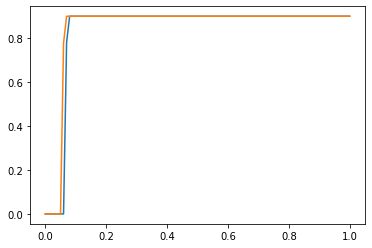

In [20]:
plt.plot(t, np.swapaxes(u,0, 1))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

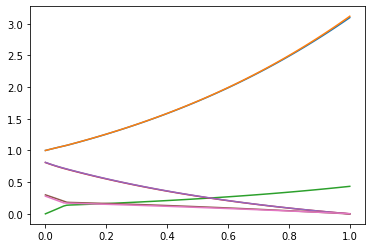

In [21]:
plt.plot(t, np.swapaxes(res,0, 1))
plt.show

In [22]:
g_coefs

array([1.43828767, 0.69637766, 1.98190519, 2.11846774])

In [ ]:
a = np.array([-1.0,0.5])
abs(a.max())